In [6]:
import numpy as np # Standard python maths library

import matplotlib.pyplot as plt # Graph plotting tools
plt.show()
plt.rcParams['figure.figsize'] = [30, 5] # matplotlib settings, define size of graph. Edit if the graphs do not fit on your screen
plt.show()

import torch # Machine learning libary being used for LSTM
from torch import nn # Commonly used module of torch library

import statsmodels.api as sm

import pandas as pd
import datetime as dt

In [2]:
ricePath = r"C:\Users\ray\Documents\Summer Project\Data\Futures\Rough Rice Futures Historical Data.csv"

In [3]:
riceData = pd.read_csv(ricePath, header=[0,1])
riceData.columns = [x[0] for x in riceData.columns]

riceData.Date = pd.to_datetime(riceData.Date)

riceData = riceData.sort_values("Date")

In [181]:
class LSTM_multifeature(nn.Module):
    def __init__(self, input_features, hidden_layers_1=32, hidden_layers_2=32, hidden_layers_3=32, outputLayer=1):
        """ Instantiate the LSTM with multiple hidden layers
            In this case, I'm using two hidden layers, and a linear layer to convert the output to a single number """
        super(LSTM_multifeature, self).__init__()
        self.input_features = input_features
        self.hidden_layers_1 = hidden_layers_1
        self.hidden_layers_2 = hidden_layers_2
        self.hidden_layers_3 = hidden_layers_3
        self.lstm1 = nn.LSTMCell(self.input_features, self.hidden_layers_1)
        self.lstm2 = nn.LSTMCell(self.hidden_layers_1, self.hidden_layers_2)
        self.lstm3 = nn.LSTMCell(self.hidden_layers_2, self.hidden_layers_3)
        self.linear = nn.Linear(self.hidden_layers_3, 1)
        
        self.last_loss = 0  # For printing purposes during training
        
    def forward(self, y, future_preds=0):
        """ Call the model to make predictions
            h_t and c_t are the hidden and cell states of the lstm layers
            
            This forward function runs through the data one point at a time, and stores the models output for each point
            If future_preds > 0 is passed in, the model with make predictions based on its own output. It is currently very bad at this.
        """
        outputs, num_samples = [], y.shape[0]
        h_t = torch.zeros(1, self.hidden_layers_1, dtype=torch.float32)
        c_t = torch.zeros(1, self.hidden_layers_1, dtype=torch.float32)
        h_t2 = torch.zeros(1, self.hidden_layers_2, dtype=torch.float32)
        c_t2 = torch.zeros(1, self.hidden_layers_2, dtype=torch.float32)
        h_t3 = torch.zeros(1, self.hidden_layers_2, dtype=torch.float32)
        c_t3 = torch.zeros(1, self.hidden_layers_2, dtype=torch.float32)
        
        for time_step in y.split(1, dim=0):
            h_t, c_t = self.lstm1(time_step, (h_t, c_t)) # initial hidden and cell states
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2)) # new hidden and cell states
            h_t3, c_t3 = self.lstm3(h_t2, (h_t3, c_t3)) # new hidden and cell states
            output = self.linear(h_t3).reshape(1) # output from the last FC layer
            outputs.append(output)
        
        new_input = torch.cat([time_step[0], output], dim=0)[1:].reshape(1, self.input_features)
        for i in range(future_preds):
            # Mirrors the code above, using last output/prediction as input
            h_t, c_t = self.lstm1(new_input, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            h_t3, c_t3 = self.lstm3(h_t2, (h_t3, c_t3))
            output = self.linear(h_t3).reshape(1)

            new_input = torch.cat([new_input[0], output], dim=0)[1:].reshape(1, self.input_features)
            outputs.append(output)
        # transform list to tensor    
        outputs = torch.cat(outputs, dim=0)
        return outputs

    
def training_loop_multifeature(n_epochs, model, optimiser, loss_fn, 
                  train_input, train_target, test_input, test_target, test=True):
    """ Train a model with provided data
        Ignorning the auto plotting part for now """
    for i in range(n_epochs):
        print("Epoch: ", i)
        def closure():
            optimiser.zero_grad()
            out = model(train_input)
            # print(list(zip(out, train_target)))
            loss = loss_fn(out, train_target)
            # print("!")
            # print(out[:10])
            # print("-")
            # print(train_target[:10])
            # print(loss)
            loss.backward()
            model.last_loss = loss
            return loss
        
        optimiser.step(closure)
        print("Loss: ", model.last_loss)
        
        # Make future predictions
    if test:
        with torch.no_grad():
            future = len(test_target)
            pred = model(torch.cat([train_input, test_input], dim=0), future_preds=future)
            print(pred.shape)
            # print(pred)
            loss = loss_fn(pred.reshape(pred.shape[1])[-future:], test_target)
            y = pred.detach().numpy()

        return (loss, y)
    
    return None

In [4]:
class LSTM_multifeature(nn.Module):
    def __init__(self, input_features, hidden_lstm_layers=[32]):
        """ Instantiate the LSTM with multiple hidden layers
            This version can construct a model with an abritrary number of hidden layers, of arbritrary size """
        super(LSTM_multifeature, self).__init__()
        self.input_features = input_features
        self.hidden_lstm_layers = hidden_lstm_layers
        self.lstm_layers = []
        layer_counts = [input_features] + hidden_lstm_layers
        
        for i in range(len(layer_counts)-1):
            self.lstm_layers.append(nn.LSTMCell(layer_counts[i], layer_counts[i+1]))
        
        self.out_layer = nn.Linear(layer_counts[-1], 1)
        
        self.last_loss = 0  # For printing purposes during training
        
    def forward(self, y, future_preds=0):
        """ Call the model to make predictions
            h_t and c_t are the hidden and cell states of the lstm layers
            
            This forward function runs through the data one point at a time, and stores the models output for each point
            If future_preds > 0 is passed in, the model with make predictions based on its own output. It is currently very bad at this.
        """
        outputs, num_samples = [], y.shape[0]
        
        h_t = [None] + [torch.zeros(1, n,  dtype=torch.float32) for n in self.hidden_lstm_layers]
        c_t = [torch.zeros(1, n,  dtype=torch.float32) for n in self.hidden_lstm_layers]
        
        for time_step in y.split(1, dim=0):
            h_t[0] = time_step
            for i in range(len(c_t)):
                h_t[i+1], c_t[i] = self.lstm_layers[i](h_t[i], (h_t[i+1], c_t[i])) # initial hidden and cell states
            
            output = self.out_layer(h_t[-1]) # output from the last FC layer
            outputs.append(output)
        
        new_input = torch.cat([time_step[0], output[0]], dim=0)[1:].reshape(1, self.input_features)
        for i in range(future_preds):
            h_t[0] = new_input
            for i in range(len(c_t)):
                h_t[i+1], c_t[i] = self.lstm_layers[i](h_t[i], (h_t[i+1], c_t[i])) # initial hidden and cell states
            
            output = self.out_layer(h_t[-1])

            new_input = torch.cat([new_input[0], output[0]], dim=0)[1:].reshape(1, self.input_features)
            outputs.append(output)
        # transform list to tensor    
        outputs = torch.cat(outputs, dim=1)
        return outputs

    
def training_loop_multifeature(n_epochs, model, optimiser, loss_fn, 
                  train_input, train_target, test_input, test_target, 
                  num_batches=1, min_batch_length=100, random_seed=100):
    """ Train a model with provided data
        Ignorning the auto plotting part for now """
    
    torch.manual_seed(random_seed)
    random.seed(random_seed)
    np.random.seed(random_seed)
    
    for i in range(n_epochs):
        if num_batches > 1:
            while True:
                batchIndices = sorted([0] + [random.randint(0, len(train_input)) for x in range(num_batches-1)] + [len(train_input)])
                min_batch = min([y-x for x, y in zip(batchIndices[:-1], batchIndices[1:])])
                if min_batch >= min_batch_length:
                    break
            batches, batchY = [], []
            for n in range(num_batches):
                batches.append((train_input[batchIndices[n]:batchIndices[n+1]],
                                train_target[batchIndices[n]:batchIndices[n+1]]))
        else:
            batches = [(train_input, train_target)]
            batchIndices = None
        
        print("Epoch: ", i, ", Batch Indicies: ", batchIndices)
        random.shuffle(batches)
        for x, y in batches:
            def closure():
                optimiser.zero_grad()
                out = model(x)
                out = out.reshape(out.shape[1])
                loss = loss_fn(out, y)
                loss.backward()
                model.last_loss = loss
                return loss
            
            optimiser.step(closure)
            print("Loss: ", model.last_loss)
        
    # Make future predictions
    if len(test_input) > 0:
        with torch.no_grad():
            future = len(test_target)
            pred = model(torch.cat([train_input, test_input], dim=0), future_preds=future)
            print(pred.shape)
            print(pred)
            loss = loss_fn(pred.reshape(pred.shape[1])[-future:], test_target)
            y = pred.detach().numpy()
    else:
        loss, y = None, None

    return (loss, y)


def train_neural_net(data, num_features, test_size, future_holdout, 
                     hidden_lstm_layers, criterion, optimiser, learning_rate, 
                     epochs, batches, min_batch_length, random_seed, print_results):
    
    np.random.seed(random_seed)
    random.seed(random_seed)
    
    num_samples = len(data)

    windowData = np.array(data[:num_features+1])
    for i in range(1, num_samples - num_features):
        windowData = np.vstack((windowData, data[i:i+num_features+1]))

    trainData = windowData[:-(test_size+future_holdout)]
    testData = windowData[-(test_size+future_holdout):-future_holdout]

    newTrainX = torch.tensor(trainData[:,:-1], dtype=torch.float32)
    newTrainY = torch.tensor(trainData[:,-1], dtype=torch.float32)

    newTestX = torch.tensor(testData[:,:-1], dtype=torch.float32)
    newTestY = torch.tensor(testData[:,-1], dtype=torch.float32)
    
    model = LSTM_multifeature(input_features=num_features, hidden_lstm_layers=hidden_lstm_layers)
    criterion = nn.MSELoss()
    optimiser = torch.optim.LBFGS(model.parameters(), lr=learning_rate)
    
    
    print(len(newTrainX), len(newTestX))
    # Train the model
    r = training_loop_multifeature(epochs, model, optimiser, criterion, newTrainX, newTrainY, newTestX, newTestY, 
                                   num_batches=batches, min_batch_length=min_batch_length, random_seed=random_seed)

    with torch.no_grad():
        future = 1000
        pred = model(torch.cat([newTrainX, newTestX], dim=0), future_preds=future)
        # print(pred[0])
        bigPred = pred[0].detach().numpy()
    
    presentPred = bigPred[:-future_holdout]
    futurePred = bigPred[-future_holdout:]

    presentTrue = base_y[num_features:-future_holdout]
    futureTrue = base_y[-future_holdout:]

    error = np.sqrt(np.mean((presentPred - presentTrue)**2))
    print("Error: ", error)
    print("RMSE: ", RMSE(presentPred, presentTrue))

    futureErrorWindow = 200
    futureErrors = abs(futurePred[:futureErrorWindow] - futureTrue[:futureErrorWindow])
    
    results = {
        "Full Prediction" : bigPred,
        "RMSE" : error, 
        "FutureErrors" : futureErrors,
    }
    
    modelString = """Features: {},
        Future Holdout: {},
        Hidden Layers: {},
        Learning Rate: {},
        Epochs: {},
        Batches: {}, 
        Min Batch Size: {},
        Random Seed: {}""".format(
            num_features, future_holdout, "[" + ", ".join([str(x) for x in hidden_lstm_layers]) + "]", 
            learning_rate, epochs, batches, min_batch_length, random_seed)

    results = {
        "Desc" : modelString, 
        "Model" : model, 
        "Full Pred" : bigPred, 
        "Future Errors": futureErrors,
    }
    
    if print_results:
        print(modelString)
        
        plt.plot(bigPred, color="r")
        plt.plot(base_y[num_features:])
        # plt.axvline(x=900)
        plt.axvline(x=len(data) - future_holdout)
        plt.show()
        
        print("Error: ", error)
        print("RMSE: ", RMSE(presentPred, presentTrue))
        
        plt.plot(futureErrors, color="r")
        plt.show()
    
    return results

3865 3865
torch.Size([3365, 55]) torch.Size([3365])
Epoch:  0
Loss:  tensor(6.3646, grad_fn=<MseLossBackward0>)
Epoch:  1
Loss:  tensor(5.9805, grad_fn=<MseLossBackward0>)
Epoch:  2
Loss:  tensor(7.4275, grad_fn=<MseLossBackward0>)
Epoch:  3
Loss:  tensor(4.2042e+11, grad_fn=<MseLossBackward0>)
Epoch:  4
Loss:  tensor(1.8030e+10, grad_fn=<MseLossBackward0>)
Epoch:  5
Loss:  tensor(5456850., grad_fn=<MseLossBackward0>)
Epoch:  6
Loss:  tensor(2228035.5000, grad_fn=<MseLossBackward0>)
Epoch:  7
Loss:  tensor(2109215.5000, grad_fn=<MseLossBackward0>)
Epoch:  8
Loss:  tensor(2099114.2500, grad_fn=<MseLossBackward0>)
Epoch:  9
Loss:  tensor(2053920., grad_fn=<MseLossBackward0>)


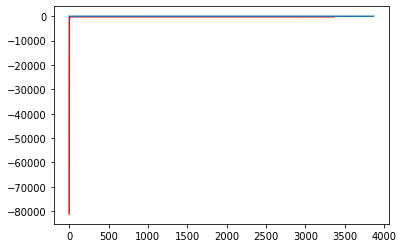

In [202]:
x = np.array(np.array(riceData.Price))

num_features = 55
num_samples = len(x)


windowData = np.array(x[:num_features])
for i in range(1, num_samples - num_features):
    windowData = np.vstack((windowData, x[i:i+num_features]))

y = torch.tensor(windowData[1:, -1], dtype=torch.float32)
x = torch.tensor(windowData[:-1], dtype=torch.float32)

testLength = 500
print(len(x), len(y))
# print(x)

trainX = x[:-testLength]
testX = x[-testLength:]

trainy = y[:-testLength]
testy = y[-testLength:]

lstmModel = LSTM_multifeature(input_features=num_features, hidden_layers_1=32, hidden_layers_2=32, hidden_layers_3=32, outputLayer=1)
criterion = nn.MSELoss()
optimiser = torch.optim.LBFGS(lstmModel.parameters(), lr=0.08)

print(trainX.shape, trainy.shape)
# Train the model
r = training_loop_multifeature(10, lstmModel, optimiser, criterion, trainX, trainy, testX, testy, test=False)

with torch.no_grad():
    future = 0
    pred = lstmModel(trainX, future_preds=future)
    # print(pred[0])
    bigPred = pred.detach().numpy()

plt.plot(bigPred, color="r")
plt.plot(y)
# plt.axvline(x=900)
plt.show()

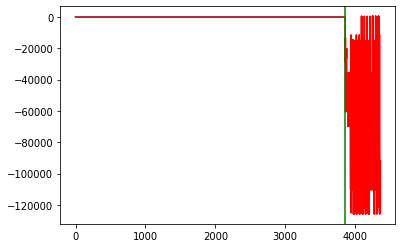

In [205]:
with torch.no_grad():
    future = 500
    pred = lstmModel(x, future_preds=future)
    # print(pred[0])
    bigPred = pred.detach().numpy()

a = np.mean(bigPred)
b = bigPred+(bigPred-a)
    
plt.plot(y[10:])
plt.plot(bigPred[10:], color="r")
plt.axvline(x=len(b[10:])-testLength, color="g")
plt.show()

3865 3865
torch.Size([3365, 55]) torch.Size([3365])
Epoch:  0
Loss:  tensor(6.1974, grad_fn=<MseLossBackward0>)
Epoch:  1
Loss:  tensor(5.9542, grad_fn=<MseLossBackward0>)
Epoch:  2
Loss:  tensor(4.4741, grad_fn=<MseLossBackward0>)


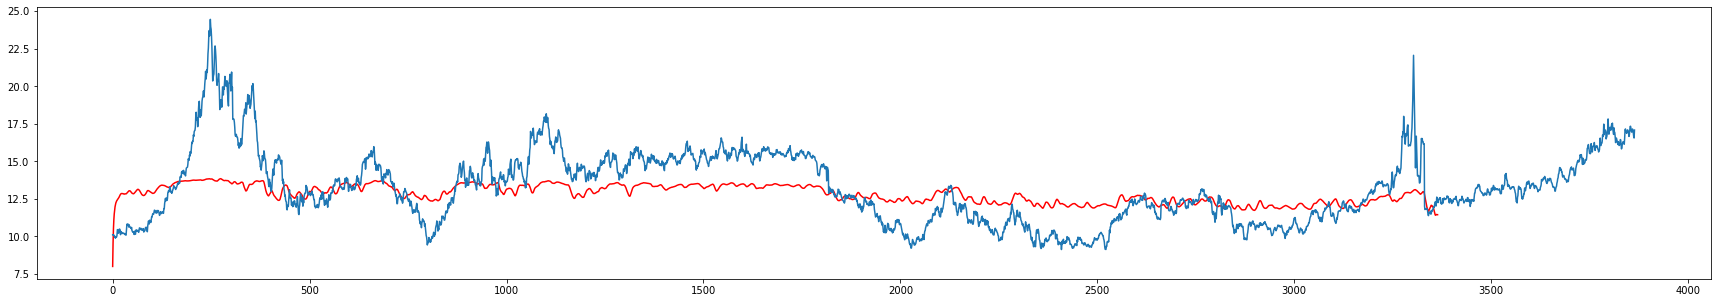

In [209]:
x = np.array(np.array(riceData.Price))

num_features = 55
num_samples = len(x)


windowData = np.array(x[:num_features])
for i in range(1, num_samples - num_features):
    windowData = np.vstack((windowData, x[i:i+num_features]))

y = torch.tensor(windowData[1:, -1], dtype=torch.float32)
x = torch.tensor(windowData[:-1], dtype=torch.float32)

testLength = 500
print(len(x), len(y))
# print(x)

trainX = x[:-testLength]
testX = x[-testLength:]

trainy = y[:-testLength]
testy = y[-testLength:]

lstmModel = LSTM_multifeature(input_features=num_features, hidden_layers_1=32, hidden_layers_2=32, hidden_layers_3=32, outputLayer=1)
criterion = nn.MSELoss()
optimiser = torch.optim.LBFGS(lstmModel.parameters(), lr=0.08)

print(trainX.shape, trainy.shape)
# Train the model
r = training_loop_multifeature(3, lstmModel, optimiser, criterion, trainX, trainy, testX, testy, test=False)

with torch.no_grad():
    future = 0
    pred = lstmModel(trainX, future_preds=future)
    # print(pred[0])
    bigPred = pred.detach().numpy()

plt.plot(bigPred, color="r")
plt.plot(y)
# plt.axvline(x=900)
plt.show()

In [ ]:
x = np.array(np.array(riceData.Price))



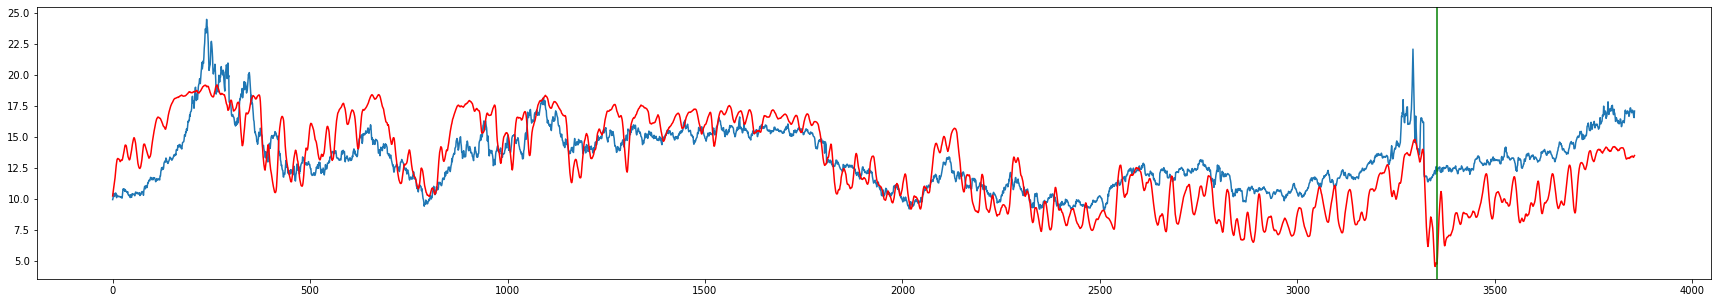

In [214]:
with torch.no_grad():
    future = 0
    pred = lstmModel(x, future_preds=future)
    # print(pred[0])
    bigPred = pred.detach().numpy()

a = np.mean(bigPred)
b = bigPred+(bigPred-a)*5
    
plt.plot(y[10:])
plt.plot(b[10:], color="r")
plt.axvline(x=len(b[10:])-testLength, color="g")
plt.show()

In [40]:
oilPath=r"C:\Users\ray\Documents\Summer Project\Data\Oil Prices\Europe_Brent_Spot_Price_FOB_Daily.csv"

In [72]:
oilData = pd.read_csv(oilPath, skiprows=[0,1,2,3])
oilData.columns = [x[0] for x in oilData.columns]

oilData["Date"] = pd.to_datetime(oilData.D)
oilData["Oil_Price"] = oilData.S


oilData = oilData.drop(["D", "S"], axis=1) \
                 .sort_values("Date")

# oilData = oilData.sort_values("Date")

In [178]:
joinData = riceData[["Date", "Price"]].set_index("Date").join(oilData.set_index("Date"), how="inner")

In [212]:
joinData

,Price,Oil_Price
Date,,
2007-01-19,10.360,52.29
2007-01-22,10.105,54.34
2007-01-23,10.270,53.93
2007-01-24,10.175,55.11
2007-01-25,10.190,55.67
...,...,...
2022-08-16,16.900,95.36
2022-08-17,16.665,97.22
2022-08-18,16.555,96.35


In [195]:
x = np.array(joinData)

num_features = 2
num_samples = len(x) - 1

y = torch.tensor(x[1:,0], dtype=torch.float32)
x = torch.tensor(x[:-1], dtype=torch.float32)

testLength = 500

trainX = x[:-testLength]
testX = x[-testLength:]

trainy = y[:-testLength]
testy = y[-testLength:]

lstmModel_oil = LSTM_multifeature(input_features=num_features, hidden_layers_1=32, hidden_layers_2=32, hidden_layers_3=32, outputLayer=1)
criterion = nn.MSELoss()
optimiser = torch.optim.LBFGS(lstmModel_oil.parameters(), lr=0.08)

r = training_loop_multifeature(5, lstmModel_oil, optimiser, criterion, trainX, trainy, testX, testy, test=False)


Epoch:  0
Loss:  tensor(6.5196, grad_fn=<MseLossBackward0>)
Epoch:  1
Loss:  tensor(5.7734, grad_fn=<MseLossBackward0>)
Epoch:  2
Loss:  tensor(4.7351, grad_fn=<MseLossBackward0>)
Epoch:  3
Loss:  tensor(1.9638, grad_fn=<MseLossBackward0>)
Epoch:  4
Loss:  tensor(1.2851, grad_fn=<MseLossBackward0>)


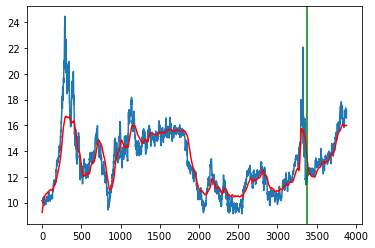

In [201]:
with torch.no_grad():
    future = 0
    pred = lstmModel_oil(x, future_preds=future)
    # print(pred[0])
    bigPred = pred.detach().numpy()

a = np.mean(bigPred)
b = bigPred+(bigPred-a)

plt.plot(y[10:])
plt.plot(bigPred[10:], color="r")
plt.axvline(x=len(b[10:])-testLength, color="g")
plt.show()